# Dense Linear Algebra in NumPy and SciPy

## Linear Algebra

Linear Algebra is *the* fundamental building block in scientific computing.  Why?  Even if we are dealing with complicated functions, we can always deal with approximations.  If we want to understand a function near a point (sample), the simplest approximation is the *constant* function, which says the function is the same everywhere.  This isn't very interesting.  The next level of approximation is a *linear* approximation, where we model the rate of change near that point. This is *much* more useful, even if it isn't exact, and opens up the possibility of saying all kinds of things about the system that we're studying.

In other words, you can do a lot with degree-1 Taylor series.

Let's first recall some definitions from your mathematics classes:

A **vector space** $V$ over a field $\mathbb{F}$ consists of a set of vectors which are related by addition and scalar multiplication
1. $v, w\in V$ implies $v + w \in V$ (addition)
2. $v \in V, \alpha \in \mathbb{F}$ implies $\alpha v \in \mathbb{F}$

These operations are associative and commutative, etc.  Usually what makes things interesting is the existence of a linear map.

A **linear map** $M: V\to W$ is a map from one vector space ($V$) to another ($W$, over the same field $\mathbb{F}$) which satisfies
$M(\alpha v + \beta w) = \alpha M v + \beta M w$

Matrices encode a linear map when we have chosen bases for both $V$ and $W$.

In scientific computing the field $\mathbb{F}$ is typically either the real numbers $\mathbb{R}$ or complex numbers $\mathbb{C}$ (but remember we use floating point arithmetic)

We will also deal with finite dimensional vector spaces. Sometimes these are explicitly vectors in Euclidean space (e.g. in computational geometry), but more often are some sort of function space.


### Householder Notation

Householder notations is standard in numerical linear algebra:
* scalars (elements of $\mathbb{F}$) are denoted with lower-case Greek letters $\alpha, \beta, \dots$
* vectors are denoted with lower-case Latin letters $a, b, \dots, w, v, \dots$
* matrices are denoted with capital letters (Latin or Greek), such as $A, B, \dots$

This was introduced by Householder (see his book "Theory of Matrices in Numerical Analysis", or the modern text "Matrix Computations" by Golub and Van Loan).

### What Do we Compute?

* **basic operations** - e.g. compute $y$ where $y = Ax$
* **solving linear systems** - find $x$ where $Ax = b$.
* **matrix analysis** - understand the action of the matrix $A$ via eigenvalues, SVD, etc.

## Some Places where Linear Algebra Appears

1. Linear regression (example of linear system)
2. Principal components analysis (example of matrix analysis)
3. Solving ODE/PDE (depending on details, involves basic operations and solving linear systems)
4. Data Visualization (often use matrix analysis)
5. Optimization (gradient descent uses basic operations, Newton's method solves a linear system)
6. Imaging - (basic operations, solving systems, some matrix analysis)

And the list goes on.

### Example: Diffusion

One example where linear algebra appears is in measuring the strength of a signal at several sources from receivers.  Consider a simplified problem where we have several points that emit some pollutant.  We aren't able to measure this pollutant directly at the sources.  This can happen for a variety of reasons, such as:
1. The pollutant is completely inaccessible (e.g. far underwater)
2. We're not able to get close for political reasons (people responsible won't cooperate)
3. It is much cheaper to measure from other locations where we already have equipment

And so on.  This problem is related to a variety of other problems in modeling heat or electromagnetic or acoustic signals, and is useful in imaging/remote sensing.  We'll denote the source locations with $x$, and the receiver locations with $y$.  We'll put these in a 2-dimensional plane

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


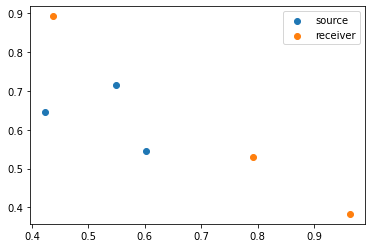

In [2]:
nx = 3
ny = 3
np.random.seed(0)
x = np.random.rand(nx, 2)
y = np.random.rand(ny, 2)
plt.scatter(x[:,0], x[:,1], label='source')
plt.scatter(y[:,0], y[:,1], label='receiver')
plt.legend()
plt.show()

Each source emits the pollutant at rate $f$.  We represent this with a vector, where `f[i]` is the pollutant emitted by source `i`.

In [3]:
f = np.random.rand(nx)
f

array([0.56804456, 0.92559664, 0.07103606])

We'll assume the pollutant spreads via diffusion.  What follows next might look familiar if you have taken some Physics classes before.  If not, don't worry - the basic idea is that pollution spreads out evenly from each source.  As we get further away from the source, the pollution becomes less concentrated because it is spread out over a larger area.  The function that tells us the concentration of a unit of pollution emitted by the source some distance away is called the *Greens function*.


Let $p$ denote the strength of the pollutant as a function in the 2-dimensional plane.  This means that diffusion obeys the PDE $\Delta p = \sum_i f_i \delta_{x_i} $, where $\Delta$ is the laplacian, and $\delta$ is a dirac delta. We're just going to measure the pollutant at the points $y$, where the receivers are located. The amount of pollutant at receiver $j$ from source $i$ is $-f_i \frac{1}{2\pi} \log \| x_i - y_j\|_2$ (this is the Green's function for $\Delta$).  Because the total amount of pollution at each reciever is the sum of the pollution from each source measured at that receiver, we can write

$p = G f$

where `p[j]` is the pollution at `y[j]`, `f[i]` is the rate of pollution at source `x[i]`, and `G[i,j]` is $-\frac{1}{2\pi} \log \|x_i - y_j\|_2$

In [4]:
G = np.empty((ny, nx), dtype=np.float)
for i in range(nx):
    for j in range(ny):
        G[i,j] = -1.0/(2*np.pi) * np.log(np.linalg.norm(x[i] - y[j]))
        
G

array([[0.2493779 , 0.10068884, 0.18840228],
       [0.15224308, 0.14768804, 0.26461807],
       [0.22302595, 0.08119219, 0.15141249]])

Now, we can calculate the concentration of pollution at the receivers using matrix-vector multipication

In [5]:
p = G @ f
p

array([0.24823837, 0.24197783, 0.21259564])

However, the point is that we want to solve the inverse problem, which is to determine how much each source is polluting from our measurements at the receivers.  In words, we want to find $f$ so that $Gf = p$ for some known $p$.

If you were to write down the solution, you would find $f = G^{-1} p$.  However, you should **never** explicilty invert a matrix on a computer, because you often run into inaccuracy due to floating point representation error. For now, we'll use `np.linalg.solve`

In [6]:
f2 = np.linalg.solve(G, p)
np.linalg.norm(f2 - f)

1.1131646879500669e-14

We see that the vector we solved for (`f2`) is very close to the true solution of `f`, and is close to machine precision.

We are able to accurately obtain the rates at which the sources release pollution based on measurements from some randomly placed sensors.

## Linear Algebra In NumPy

### Basic Operations

Vectors and matrices in NumPy are represented using `np.ndarray`, which we have seen already.  Here is a review:

In [7]:
n = 3 # dimension of vector space
a, b = 1.5, 2.0 # scalars
x, y = np.random.rand(n), np.random.rand(n)

a*x + b*y # scalar multiplication and vector addition

array([1.68700745, 1.77035189, 3.20616645])

In [8]:
m = 4 # dimension of target vector space

A = np.random.randn(m, n) # random linear transformation
z = A @ (a*x + b*y)
z # image

array([ 0.98960871, -0.02812151, -3.75157541,  3.47067757])

In [9]:
z2 = a * A @ x + b * A @ y
z2

array([ 0.98960871, -0.02812151, -3.75157541,  3.47067757])

In [10]:
z - z2 # difference of image computed in two ways

array([-2.22044605e-16, -2.77555756e-16,  0.00000000e+00, -4.44089210e-16])

In [11]:
k = 3
B = np.random.randn(k, m) # new linear map
z = (B @ A) @ x
z2 = B @ (A @ x)
z - z2

array([-9.71445147e-17,  0.00000000e+00, -2.22044605e-16])

### Solving Linear Systems

Recall from our example that for numerical reasons, you should never invert a matrix to solve a linear system. Let's see an example where we solve `A * x = b` for `x`

In [12]:
import numpy.linalg as la
import time

In [13]:
n = 1000
A = np.random.randn(n,n)
x = np.random.rand(n)
b = A @ x

In [14]:
t0 = time.time()
Ainv = la.inv(A) # use inversion
x2 = Ainv @ b
t1 = time.time()
print("{} sec.".format(t1 - t0))
la.norm(x - x2)

0.0690619945526123 sec.


3.5132522804291944e-11

In [15]:
t0 = time.time()
x2 = la.solve(A, b) # use solve function
t1 = time.time()
print("{} sec.".format(t1 - t0))
la.norm(x - x2)

0.013466835021972656 sec.


3.0873995407380632e-12

We see that you will get a more precise answer, and faster when using `solve` instead of a matrix inverse.

If we want to do a least squares solve: $\min_x \|Ax - b\|$

We can use `lstsq`.  For full-rank (square) matrices, this is equivalent to `solve`.



In [16]:
x1 = la.solve(A, b)
x2 = la.lstsq(A, b, rcond=None)[0]
la.norm(x1 - x2)

7.409151322719202e-12

`lstsq` can also be used with over-and under determined linear systems

In [17]:
m = 1000
n = 500
A = np.random.randn(m, n)
x = np.random.rand(n)
b = A @ x

x2 = la.lstsq(A, b, rcond=None)[0]
la.norm(x - x2)

4.474003749662003e-14

in the above case, we are able to solve the system exactly because `b` in in the image of `A`

In [18]:
m = 500
n = 1000
A = np.random.randn(m, n)
x = np.random.rand(n)
b = A @ x

x2 = la.lstsq(A, b, rcond=None)[0]
la.norm(x - x2)

12.784556981877794

in the above case, there are many possiblities for `x` where `A*x = b`, so we find the smallest-norm solution

## SciPy Linear Algebra

We're now going to switch gears and start using `scipy.linalg` instead of `numpy.linalg`.  From the user's point of view, there isn't really any difference, except `scipy.linalg` has all the same functions as `numpy.linalg` as well as additional functions.  The call signatures are essentially the same, but there are sometimes different implementations under the hood.

* [NumPy linear algebra documentation](https://numpy.org/doc/stable/reference/routines.linalg.html)
* [SciPy linear algebra documentation](https://docs.scipy.org/doc/scipy/reference/linalg.html)

SciPy is built on top of the NumPy `ndarray` data type, so it is fully interoperable.  For example:

In [19]:
import scipy as sp
import scipy.linalg as sla

n = 1000
A = np.random.randn(n,n)
x = np.random.rand(n)
b = A @ x

x1 = la.solve(A, b) # numpy
x2 = sla.solve(A, b) # scipy
la.norm(x1 - x2)

0.0

We'll just import `scipy.linalg` into the `la` namespace, replacing `numpy.linalg`

In [20]:
import scipy.linalg as la

## Matrix Factorizations

A **matrix factorization** or **matrix decomposition** writes a matrix $A$ as the product of matrices $A = BCD\dots$, where the matrices in the product typically have some special structure.

Here are some examples:
* Diagonal matrices - easy to apply and solve linear systems
* Triangular matrices (upper or lower) - fast to solve linear systems
* Orthonormal matrices: $Q$ orthogonal means $Q^T = Q^{\dagger}$ (pseudoinverse)
* Permutation matrices: sparse orthonormal matrices

Most of the matrix factorizations we will see run in $O(n^3)$ time for a $n\times n$ matrix $A$, or $O(\min(m,n)^2 \max(m,n))$ for a $m\times n$ matrix $A$.

If you want to get really in-depth into how to compute matrix factorizations, take a numerical linear algebra course.  We'll get them treating scipy as a black box (meaning we don't look inside).

### LU decomposition

The first type of factorization we'll look at is a $LU$ decomposition, where $L$ is lower-triangular and $U$ is upper triangular.  For numerical stability, this is often computed with a *pivoting* strategy, which means there is also row or column permutation matrix $P$.
$$ A = PLU$$

In [21]:
n = 1000
A = np.random.randn(n, n)
x = np.random.rand(n)
b = A @ x

P, L, U = la.lu(A)

In [22]:
la.norm(P @ L @ U - A)

5.7066142766788165e-12

The nice thing about triangular matrices is that they can solve linear systems in $O(n^2)$ time, instead of $O(n^3)$ time for general matrices, using the forward or backward substitution algorithms.  There is a special function `solve_triangular` for this reason:

In [23]:
y = L @ x
x2 = la.solve_triangular(L, y, lower=True)
la.norm(x2 - x)

9.654118103977387e-13

We can replicate the functionality of `solve` using an LU factorization, using the expression
$$A^{-1} = U^{-1} L^{-1} P^T$$

In [24]:
def my_solve(A, b):
    """
    solve A * x = b for x
    
    use LU decomposition
    """
    P, L, U = la.lu(A)
    x = la.solve_triangular(
            U,
            la.solve_triangular(
                L,
                P.T @ b,
                lower=True
            ),
            lower=False
        )
    return x

In [25]:
b = A @ x
x2 = my_solve(A, b)
la.norm(x - x2)

3.3830152231589354e-11

### Exercise

1. Use the `time` module to perform an experiment to verify that `solve_triangular` takes $O(n^2)$ time.  Hint: take LU decompositions of random matrices to get triangular factors of different sizes.

In [26]:
## Your code here

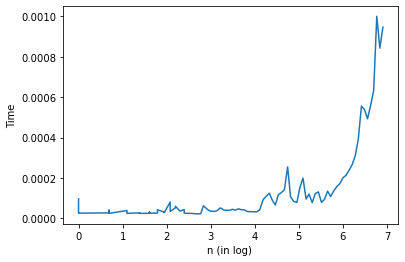

In [27]:
import time 
tlist = list()
n  = np.logspace(0,np.log10(1000), num=100) 
n = np.int64(np.round(n))

for i in n:
    A = np.random.randn(i, i)
    x = np.random.rand(i)
    b = A @ x
    P, L, U = la.lu(A)
    y = L @ x

    #Time for solve_triangular
    t0Tri = time.time()
    la.solve_triangular(L, y, lower=True)
    t1Tri = time.time()
    timeTri = t1Tri-t0Tri
    timeTri
    tlist.append(timeTri)

plt.plot(log(n),tlist, label='time vs log(n)')
plt.xlabel("n (in log) ")
plt.ylabel("Time")
plt.show()

2. Suppose $A$ is $n\times n$, so the $LU$ factorization above takes $O(n^3)$ time.  What is a big-O expression for the time to run `my_solve` on $A$? 

The big-O expression for the time to run my_solve on A is O(n^3) + O(n^2). LU factorization takes O(n^3) and each inverse of a triangular matrix takes O(n^2), but two triangular matrices are still O(n^2), and then we sum them up since there is an order performing the algorithm not composed.

### QR decomposition

The $QR$ decomposition, $A = QR$, contains a matrix $Q$ with orthonormal columns, and an upper triangular matrix $R$.  For stability reasons, column pivoting is often used which means there is often a permutation matrix $P$ and $A = QRP$.

In [28]:
m = 1000
n = 500
A = np.random.randn(m, n)

Q, R = la.qr(A, mode='economic') # no pivoting
la.norm(Q @ R  - A)

4.938391665942739e-13

In [29]:
Q.shape, R.shape

((1000, 500), (500, 500))

In [30]:
Q, R, P = la.qr(A, pivoting=True) # pivoting
la.norm((Q @ R)  - A[:,P])

5.320677169957867e-13

The QR factorization is used for least-squares solutions, because `Q @ Q.T` projects a vector onto the subspace spanned by the matrix `A`

In [31]:
def my_lstsq(A, b):
    """
    least squares solution ||b - A*x||
    
    Uses QR decomposition
    """
    Q, R = la.qr(A, mode='economic')
    x = la.solve_triangular(R, Q.T @ b, lower=False)
    return x

In [32]:
x = np.random.rand(n)
b = A @ x

x1 = la.lstsq(A, b)[0]
x2 = my_lstsq(A, b)
la.norm(x1 - x2)

4.502472005077859e-14

### Excercise

Suppose $A$ is a $n\times n$ matrix, and that the $QR$ factorization takes $O(n^3)$ time.  What is the time to run `my_lstsq` using $A$ in big-O notation?

### Eigenvalue Decompositions

A vector $x$ is an eigenvector of $A$ with eigenvalue $\lambda$ if $Ax = x \lambda$.  An eigenvalue decomposition is a decomposition $A = X \Lambda X^{-1}$ where $\Lambda$ is a diagonal matrix.  We can compute such a decomposition using `eig`:

In [33]:
n = 1000
A = np.random.randn(n, n)
Lam, X = la.eig(A)

columns of `X` are eigenvectors, and eigenvalues are diagonal entries of `Lam`

In [34]:
x = X[:,0]
la.norm(A @ x - Lam[0] * x)

3.3326507463611847e-13

When `A` is symmetric (or hermitian), there exists and orthonormal basis where every basis element is an eigenvector.  In this case, we can write $A = U\Lambda U^H$.  There is a special function `eigh` for such a situation.

In [35]:
A = np.random.randn(n,n)
A = A + A.T # make symmetric
Lam, U = la.eigh(A)

In [36]:
x = U[:,0]
la.norm(A @ x - Lam[0] * x)

2.2105780945092506e-13

Computing eigenvector decompositions takes $O(n^3)$ time for a $n\times n$ matrix.

### Exercises

1. Both `eig` and `eigh` take $O(n^3)$ time.  Which is faster in practice on a symmetric matrix?  Do they produce the same answer on the same symmetric matrix?

As shown in the figure, `eigh` is much faster than `eig` in practice. We checked the eigenvalues produced by both methods (eigenvalues of `eigh` are sorted), they produced the same answer.

2. Write a function that solves a linear system with a symmetric matrix using the Eigenvalue decomposition.  Is this function faster or slower than using LU in `my_solve`?

As shown in the figure, `my_solve` is faster than `eigh` in practice. 

In [40]:
## Your code here
'''
1. Compare the speed and difference of eig & eigh
'''
n = np.logspace(0,np.log10(1000), num=100) 
n = np.int64(np.round(n))
teig=list()
teigh=list()
valdiff = list()
for i in n:
    A = np.random.randn(i,i)
    A = A + A.T
    t0eig = time.time()
    Lam1, X = la.eig(A)
    t1eig = time.time()
    teigdiff = t1eig-t0eig
    teig.append(teigdiff)
    
    t0eigh = time.time()
    Lam2, U = la.eigh(A)
    t1eigh = time.time()
    teighdiff = t1eigh-t0eigh
    teigh.append(teighdiff)
    
    valdiff.append(np.max(np.abs(np.sort(Lam1) - np.sort(Lam2))))

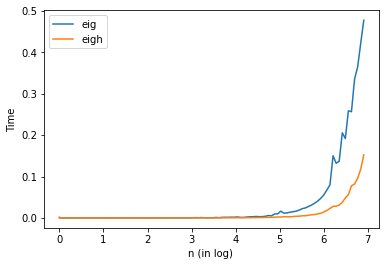

2.4442670110147446e-12

In [41]:
'''
1. Time comparison
'''
plt.plot(np.log(n),teig, label='eig')
plt.plot(np.log(n),teigh, label='eigh')
plt.xlabel("n (in log) ")
plt.ylabel("Time")
plt.legend(loc='best')
plt.show()

'''
1. Difference
'''
np.max(valdiff)

In [61]:
'''
2. Compare the speed of EVD v.s. LU when solving linear systems
'''
def solve_eigh(A, b):
    Lam, U = la.eigh(A)
    Ainv = U@np.diag(1/Lam)@U.T
    x = Ainv@b
    return(x)


n = np.logspace(0,np.log10(1000), num=100) 
n = np.int64(np.round(n))
tlu=list()
teigh=list()
valdiff = list()
for i in n:
    A = np.random.randn(i,i)
    A = A + A.T
    x = np.random.rand(i)
    b = A @ x
    t0lu = time.time()
    x1 = my_solve(A, b)
    t1lu = time.time()
    tludiff = t1lu-t0lu
    tlu.append(tludiff)
    
    t0eigh = time.time()
    x2 = solve_eigh(A,b)
    t1eigh = time.time()
    teighdiff = t1eigh-t0eigh
    teigh.append(teighdiff)

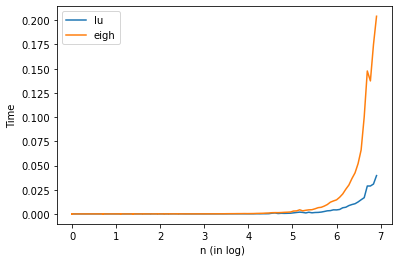

In [62]:
'''
2. Time comparison
'''
plt.plot(np.log(n),tlu, label='lu')
plt.plot(np.log(n),teigh, label='eigh')
plt.xlabel("n (in log) ")
plt.ylabel("Time")
plt.legend(loc='best')
plt.show()

### SVD

The singular value decomposition is an extremely useful practical and theoretical tool.  We can decompose a $m\times n$ matrix $A$ as $A = U \Sigma V^T$, where $U$ is a $m \times m$ matrix with orthonormal columns (called left singular vectors), $V$ is a $n\times n$ matrix with orthonormal columns (called right singular vectors), and $\Sigma$ is a diagonal matrix with positive entries decreasing in magnitude (called singular values).

The top singular value solves the variational problem $\sigma_0 = \max u^T A v$ subject to $\|u\|_2 = 1, \|v\|_2=1$, and describes the direction in which $A$ induces the largest change in maginitude in a vector. The next singular value is defined similarly on the subspaces orthogonal to $u$ and $v$, and so on.

One way to visualize the action of a matrix is seeing how it maps the unit sphere.  The image is an ellipsoid, and the right singular vectors give the directions of the axes, and the singular values give the lengths of these axes.

In [35]:
n = 2
A = np.random.randn(n,n)
U, S, Vt = la.svd(A)

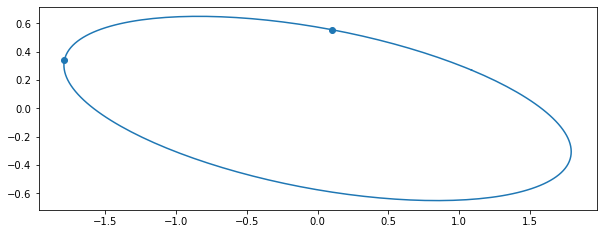

In [36]:
theta = np.linspace(0, 2*np.pi, num=200, endpoint=True)
xx = np.vstack((np.cos(theta), np.sin(theta)))
yy = A @ xx

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(yy[0], yy[1])
ax.set_aspect('equal')
ax.scatter(S*U[0], S*U[1])
plt.show()

### Exercises

1. Computing the SVD takes $O(n^3)$ time for a $n\times n$ matrix, just like all the other matrix factorizations we've seen.  Make plots of the runtimes of `svd`, `eigh`, `eig`, `qr` and `lu` as we increase $n$.  Which is fastest in practice?

From the plot, we see that from slowest to fastest is: `eig, svd, eigh, qr, lu`. `lu` is fastest in practice.

2. Write a function that solves a linear system using the Singular Value Decomposition.
3. What is the SVD of a Hermitian (symmetric matrix)?  Is `svd` or `eigh` faster?

From the last figure, we can see that `eigh` is faster on a Hermitian.

In [54]:
'''
1. Time comparison of SVD, eig, eigh, QR, LU
'''
n = np.logspace(0,np.log10(1000), num=100) 
n = np.int64(np.round(n))
tsvd=list()
teigh=list()
teig=list()
tqr=list()
tlu=list()

for i in n:
    A = np.random.randn(i,i)

    t0 = time.time()
    U, S, Vt = la.svd(A)
    t1 = time.time()
    tsvd.append(t1-t0)
    
    t0 = time.time()    
    Lam, U = la.eig(A)
    t1 = time.time()
    teig.append(t1-t0)
    
    t0 = time.time()    
    Lam, U = la.eigh(A)
    t1 = time.time()
    teigh.append(t1-t0)
    
    t0 = time.time()    
    Q, R = la.qr(A, mode='economic') # no pivoting
    t1 = time.time()
    tqr.append(t1-t0)
    
    t0 = time.time()    
    P, L, U = la.lu(A)
    t1 = time.time()
    tlu.append(t1-t0)

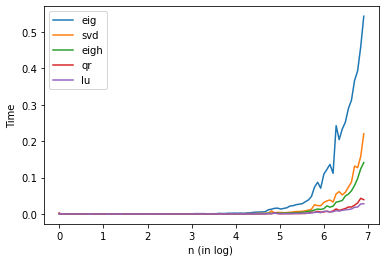

In [56]:
'''
1. Time comparison of SVD, eig, eigh, QR, LU
'''
plt.plot(np.log(n),teig, label='eig')
plt.plot(np.log(n),tsvd, label='svd')
plt.plot(np.log(n),teigh, label='eigh')
plt.plot(np.log(n),tqr, label='qr')
plt.plot(np.log(n),tlu, label='lu')
plt.xlabel("n (in log) ")
plt.ylabel("Time")
plt.legend(loc='best')
plt.show()

In [63]:
'''
2. Define a function that solves a linear system using SVD
'''
def solve_svd(A, b):
    U, S, Vt = la.svd(A)
    Ainv = U@np.diag(1/S)@Vt
    x = Ainv@b
    return(x)

In [67]:
'''
3. Compare svd and eigh on symmetric matrices
'''

n = np.logspace(0,np.log10(2000), num=100) 
n = np.int64(np.round(n))
tsvd=list()
teigh=list()

for i in n:
    A = np.random.randn(i,i)
    A = A + A.T
    t0 = time.time()
    U, S, Vt = la.svd(A)
    t1 = time.time()
    tsvd.append(t1-t0)

    t0 = time.time()    
    Lam, U = la.eigh(A)
    t1 = time.time()
    teigh.append(t1-t0)
    

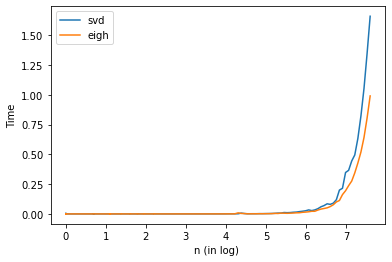

In [68]:
plt.plot(np.log(n),tsvd, label='svd')
plt.plot(np.log(n),teigh, label='eigh')
plt.xlabel("n (in log) ")
plt.ylabel("Time")
plt.legend(loc='best')
plt.show()